# Evaluations of different model over the prerpocessed data

In [15]:
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing
from sklearn.linear_model import LinearRegression, LogisticRegression, Perceptron, TheilSenRegressor
from sklearn.naive_bayes import GaussianNB
import sklearn.decomposition as decomposition
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import GradientBoostingRegressor
import os
import seaborn as sns
import pandas as pd
from custom_print import *
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.pipeline import make_pipeline

In [16]:
import datetime

class colors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    ORANGE = '\033[33m'
    RESULT =  '\033[94m'
    WARNING = '\033[93m'
    DEBUGGING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    
def now():
    return datetime.datetime.now().strftime("%H:%M:%S")

def print_error(*args, **kwargs):
    print(now()+" ["+colors.BOLD+colors.FAIL+"ERROR"+colors.ENDC+"] " +" ".join(map(str,args))+"\n", **kwargs)
    
def print_warning(*args, **kwargs):
    print(now()+" ["+colors.BOLD+colors.ORANGE+"WARNING"+colors.ENDC+"] " +" ".join(map(str,args))+ "\n", **kwargs)

def print_debugging(*args, **kwargs):
    print(now()+" ["+colors.BOLD+colors.DEBUGGING+"DEBUG"+colors.ENDC+"] " +" ".join(map(str,args))+"\n", **kwargs)
    
def print_info(*args, **kwargs):
    print(now()+" ["+colors.BOLD+colors.OKGREEN+"INFO"+colors.ENDC+"] "+" ".join(map(str,args))+"\n", **kwargs)

def print_configs(*args, **kwargs):
    print(now()+" ["+colors.BOLD+colors.OKBLUE+"CONFIGS"+colors.ENDC+"] "+" ".join(map(str,args))+"\n", **kwargs)

In [17]:
def log_regression(x,y):
    print_configs("Model: Logistic Regression")
    model = LogisticRegression(random_state=0).fit(x, y)
    return model

def svr_regression(x,y):
    print_configs("Model: SVR")
    model = LinearSVR(C=1.0, epsilon=0.2).fit(x, y)
    return model
    
def lin_regr(x, y):
    print_configs("Model: Linear Regression")
    model = LinearRegression().fit(x, y)
    return model

def grad_boost(x, y):
    print_configs("Model: Gradient Boosting")
    model = GradientBoostingRegressor(random_state=0).fit(x, y)
    return model

def perceptron(x, y):
    print_debugging("Model: Perceptron")
    model = Perceptron(tol=1e-3, random_state=0).fit(x, y)
    return model

def naive_bayes(x, y):
    print_debugging("Model: Naive Bayes")
    model = GaussianNB().fit(x, y)
    return model

def theilsen(x, y):
    print_debugging("Model: TheilSen")
    model = TheilSenRegressor(random_state=0).fit(x, y)
    return model

def ml_nn(x, y):
    print_configs("Model: Multi Layer Perceptron")
    model = MLPRegressor(random_state=1, max_iter=2000, activation='tanh', solver='lbfgs').fit(x, y)
    return model

In [18]:
def scale(x,y):
    scaler_x = preprocessing.RobustScaler()
    scaler_y = preprocessing.RobustScaler()
    x = scaler_x.fit_transform(x)
    y = y.ravel()
    return x, y, scaler_y

def evaluations(x,y, f, desc = None):
    
    if desc is not None:
        print_info(desc)
    
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)    
    
    model = f(X_train, y_train)
    train_score = model.score(X_train, y_train)
    print_info(f"Model score: {train_score}")
    model_prediction = model.predict(X_test)
    accuracy_score = model.score(X_test, y_test)
    mse = mean_squared_error(y_test, model_prediction)
    r2 = r2_score(y_test, model_prediction)
    print_info("Metrics are:\n Accuracy: {}\n MSE: {} \n R2: {}\n\n".format(accuracy_score, mse, r2))
    
    print_info("Predictions:")
    for i in range(len(y_test)//50):
        print("y_test[{}]: {}, model_prediction[{}]: {}".format(i, y_test[i], i, model_prediction[i]))
    
    return model

def linearize_input(df, side = None):
    list_status = ['CYCLE_COMPLETED', 'CYCLE_ABORTED', 'CYCLE_NOT_STARTED', 'CYCLE_COMPLETED_L', 'CYCLE_ABORTED_L', 'CYCLE_NOT_STARTED_L',
                   'CYCLE_COMPLETED_R', 'CYCLE_ABORTED_R', 'CYCLE_NOT_STARTED_R', 'cumulative_per_day_CYCLE_COMPLETED_day', 
                   'cumulative_per_day_CYCLE_ABORTED_day', 'cumulative_per_day_CYCLE_NOT_STARTED_day', 'cumulative_per_day_CYCLE_COMPLETED_L_day',
                   'cumulative_per_day_CYCLE_ABORTED_L_day', 'cumulative_per_day_CYCLE_NOT_STARTED_L_day', 'cumulative_per_day_CYCLE_COMPLETED_R_day',
                   'cumulative_per_day_CYCLE_ABORTED_R_day', 'cumulative_per_day_CYCLE_NOT_STARTED_R_day']
    df = df.drop(columns=list_status)
    col_name = df.columns.to_list()
    if side is None:
        #print([item for item in col_name if '_L' in item or '_R' in item])
        df.drop([item for item in col_name if '_L' in item or '_R' in item], axis=1, inplace=True)
    
    x = df.to_numpy()
    return x, df

def get_data(mach_index):
    file_dir = '../Data/data_per_machine/2022/processed/'
    file_list = os.listdir(file_dir)
    mach_name = [file.replace('.csv','') for file in file_list]
    file = file_dir + file_list[mach_index]
    df = pd.read_csv(file)
    current_machine = mach_name[mach_index]
    print_configs(f"Machine: {current_machine}")
    return df, current_machine

## Train-Test and evaluation of the models

10:36:55 [CONFIGS] Machine: C403

10:36:55 [CONFIGS] Machine: C103

10:36:55 [CONFIGS] Machine: 1506

10:36:55 [CONFIGS] Machine: C305

10:36:55 [CONFIGS] Machine: C105

10:36:55 [INFO] SVR

10:36:55 [CONFIGS] Model: SVR

10:36:55 [INFO] Model score: 0.041766377164918156

10:36:55 [INFO] Metrics are:
 Accuracy: -0.05072630085194141
 MSE: 184.04352255235733 
 R2: -0.05072630085194141



10:36:55 [INFO] Predictions:

y_test[0]: 5, model_prediction[0]: 4.048771746059089
y_test[1]: 7, model_prediction[1]: 13.750688894626238
y_test[2]: 24, model_prediction[2]: 12.872214759602548
10:36:55 [INFO] Linear Regression

10:36:55 [CONFIGS] Model: Linear Regression

10:36:55 [INFO] Model score: 0.3551551268405848

10:36:55 [INFO] Metrics are:
 Accuracy: 0.20985309238753913
 MSE: 138.40085671495987 
 R2: 0.20985309238753913



10:36:55 [INFO] Predictions:

y_test[0]: 5, model_prediction[0]: 6.831031947124412
y_test[1]: 7, model_prediction[1]: 15.32767146790581
y_test[2]: 24, model_prediction[2]: 19.2

/home/jawa17/.local/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


10:36:55 [DEBUG] Model: Perceptron

10:36:55 [INFO] Model score: 0.03325942350332594

10:36:55 [INFO] Metrics are:
 Accuracy: 0.03608247422680412
 MSE: 223.10824742268042 
 R2: -0.27375144885798663



10:36:55 [INFO] Predictions:

y_test[0]: 5, model_prediction[0]: 13
y_test[1]: 7, model_prediction[1]: 18
y_test[2]: 24, model_prediction[2]: 35
10:36:55 [INFO] Naive Bayes

10:36:55 [DEBUG] Model: Naive Bayes

10:36:55 [INFO] Model score: 0.09312638580931264

10:36:56 [INFO] Metrics are:
 Accuracy: 0.04639175257731959
 MSE: 338.7680412371134 
 R2: -0.9340669309058001



10:36:56 [INFO] Predictions:

y_test[0]: 5, model_prediction[0]: 0
y_test[1]: 7, model_prediction[1]: 35
y_test[2]: 24, model_prediction[2]: 26
10:36:56 [INFO] Multi Layer Perceptron

10:36:56 [CONFIGS] Model: Multi Layer Perceptron



/home/jawa17/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/tmp/ipykernel_23421/601112401.py:29: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(3,1,1)
/tmp/ipykernel_23421/601112401.py:30: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(3,1,2)
/tmp/ipykernel_23421/601112401.py:31: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is depr

10:37:02 [INFO] Model score: 0.9295724498093106

10:37:02 [INFO] Metrics are:
 Accuracy: -0.8216500338153834
 MSE: 319.0772790299137 
 R2: -0.8216500338153834



10:37:02 [INFO] Predictions:

y_test[0]: 5, model_prediction[0]: 7.91888045456448
y_test[1]: 7, model_prediction[1]: 7.594634567788194
y_test[2]: 24, model_prediction[2]: 3.3528289217230274


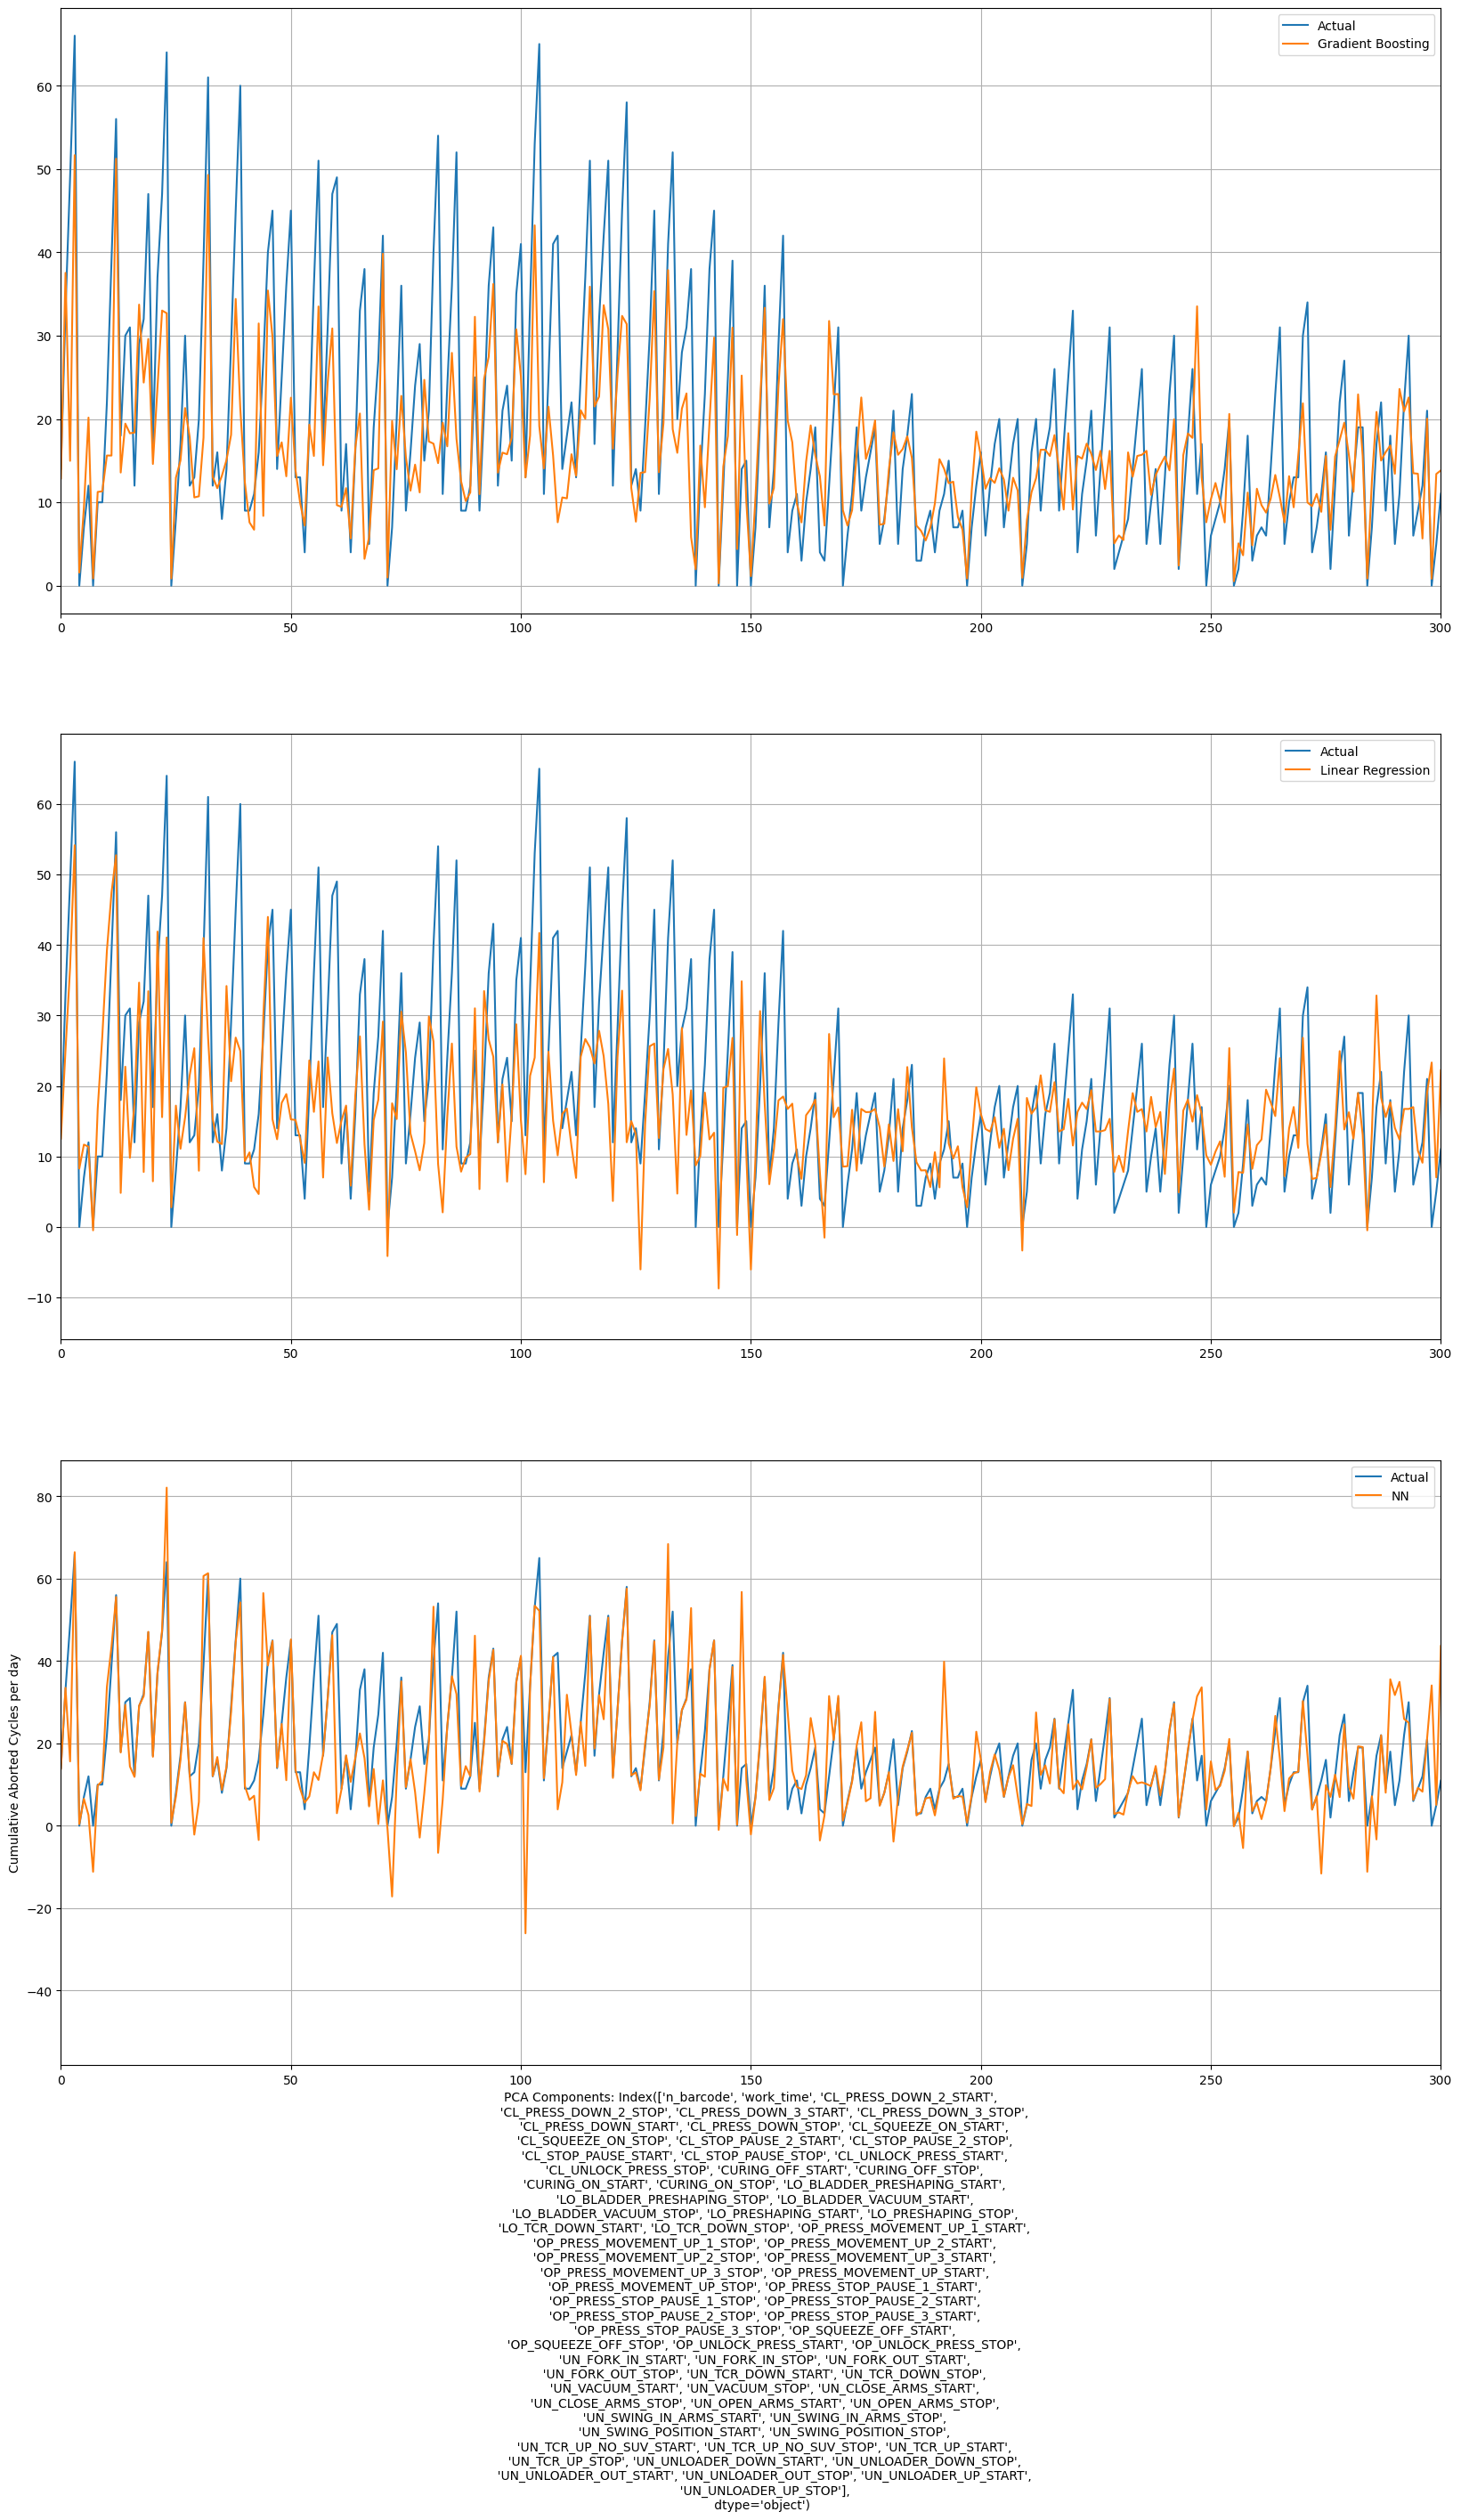

In [19]:
if __name__ == '__main__':
    train_df = []
    for i in range(5):
        df, current_machine = get_data(i)
        train_df.append(df)
    df = pd.concat(train_df)
    df = df.fillna(0)
    df.drop(columns=['y-m-day-hour_3_rounded'], inplace=True)
    x, x_df = linearize_input(df)
    y = df['cumulative_per_day_CYCLE_ABORTED_day'].to_numpy()
    
    # model = evaluations(x,y, log_regression, desc = "Logistic Regression")
    pca = decomposition.PCA(n_components=1)
    x_ = pca.fit_transform(x)
    
    scale_x, scale_y, scaler = scale(x,y)
    
    model_svr = evaluations(scale_x,scale_y, svr_regression, desc = "SVR")
    model_lin = evaluations(scale_x,scale_y, lin_regr, desc = "Linear Regression")
    model_gb = evaluations(scale_x,scale_y, grad_boost, desc = "Gradient Boosting")
    model_perceptron = evaluations(scale_x,scale_y, perceptron, desc = "Perceptron")
    model_naive_bayes = evaluations(scale_x,scale_y, naive_bayes, desc = "Naive Bayes")
    model_ml_nn = evaluations(scale_x,scale_y, ml_nn, desc = "Multi Layer Perceptron")
    
    
    # model_gb_ = evaluations_on_new_data(scale_x,scale_y, grad_boost, desc = "Gradient Boosting")
    
    figure = plt.subplots(10,3)
    ax1 = plt.subplot(3,1,1)
    ax2 = plt.subplot(3,1,2)
    ax3 = plt.subplot(3,1,3)
    
    
    
    ax1.plot(scale_y, label='Actual')
    
    ax1.plot(model_gb.predict(scale_x), label='Gradient Boosting')
    ax1.legend()
    ax1.grid()
    ax1.set_xlim(0,300)
    ax2.plot(scale_y, label='Actual')
    ax2.plot(model_lin.predict(scale_x), label='Linear Regression')
    ax2.legend()
    ax2.grid()
    ax2.set_xlim(0,300)
    ax3.plot(scale_y, label='Actual')
    ax3.plot(model_ml_nn.predict(scale_x), label='NN')
    ax3.legend()
    ax3.grid()
    ax3.set_xlim(0,300)
    figure[0].set_size_inches(20,30)
    plt.xlabel(f'PCA Components: {x_df.columns}')
    plt.ylabel('Cumulative Aborted Cycles per day')
    # plt.savefig('src/prediction/figures/evaluations_of_models_PCA_Over_COmulative_Cycle_Aborted.png')
    plt.show()